In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
with np.load('cifar4-train.npz',allow_pickle=False) as npz_file:
    data = dict(npz_file.items())
print (data.keys())

dict_keys(['pixels', 'overfeat', 'labels', 'names', 'allow_pickle'])


In [4]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [31]:
#create X/y arrays
X = data['overfeat']
y = data['labels']
X_pix = data['pixels']
X_names = data['names']
X_labels = data['labels']

X_train,X_test,y_train,y_test,pix_train,pix_test,labels_train,labels_test = train_test_split(X,y,X_pix,X_labels, test_size=1000, random_state=0)

In [34]:
sgd = SGDClassifier(loss='log',max_iter=1000, tol=1e-3, random_state=0,penalty='l2')
pca = PCA(n_components=150)
pipe = Pipeline([('pca',None),('sgdclass',sgd)])
grid_cv = GridSearchCV(pipe,[{'sgdclass__alpha':[0.001,0.01,0.1,1,10]},{'pca':[pca],'pca__n_components':[100,200,300,400,500],
                                                                        'sgdclass__alpha':[0.001,0.01,0.1,1,10]}],cv=5)
grid_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', None), ('sgdclass', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=0.001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'sgdclass__alpha': [0.001, 0.01, 0.1, 1, 10]}, {'pca': [PCA(copy=True, iterated_power='auto', n_components=500, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)], 'pca__n_components': [100, 200, 300, 400, 500], 'sgdclass__alpha': [0.001, 0.01, 0.1, 1, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [35]:
grid_cv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_sgdclass__alpha', 'param_pca', 'param_pca__n_components', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [36]:
results = pd.DataFrame.from_items([('alpha',grid_cv.cv_results_['param_sgdclass__alpha']),
                                       ('n components',grid_cv.cv_results_['param_pca__n_components']),
                                       ('mean test',grid_cv.cv_results_['mean_test_score']),
                                       ('std test',grid_cv.cv_results_['std_test_score'])
                                      ])

In [37]:
results.sort_values('mean test',ascending=False).head()

,alpha,n components,mean test,std test
2,0.1,NaN,0.83375,0.015600
21,0.01,400,0.83150,0.014492
25,0.001,500,0.83050,0.016036
15,0.001,300,0.82875,0.014922
12,0.1,200,0.82875,0.014116


In [38]:
results['mean test'].idxmax()

2

In [39]:
print ('GGD Regression - top accuracy across folds: {:.3f} (std: {:.3f}) with alpha: {} and n_components {}'
       .format(results.loc[2,'mean test'],results.loc[2,'std test'],results.loc[2,'alpha'],results.loc[2,'n components']))

GGD Regression - top accuracy across folds: 0.834 (std: 0.016) with alpha: 0.1 and n_components nan


In [40]:
accuracy = grid_cv.score(X_test,y_test)
print ('Logistic regression accuracy (test set):{:.3f}'.format(accuracy))

Logistic regression accuracy (test set):0.812


In [41]:
X_test.shape

(1000, 4096)

In [42]:
pix_test.shape

(1000, 3072)

In [43]:
probability = grid_cv.best_estimator_.predict_proba(X_test[0:10])

In [44]:
#regularization strenght of best, which is 0.1
df = pd.DataFrame(probability,columns=['truck','car','airplane','ship'])
df.round(2)

,truck,car,airplane,ship
0,0.00,0.93,0.04,0.02
1,0.00,0.56,0.06,0.38
2,0.11,0.88,0.00,0.01
3,0.00,0.02,0.15,0.83
4,0.00,0.04,0.96,0.00
5,0.61,0.13,0.01,0.26
6,0.00,0.00,0.46,0.54
7,0.02,0.09,0.00,0.89
8,0.04,0.02,0.90,0.04
9,0.00,0.14,0.78,0.08


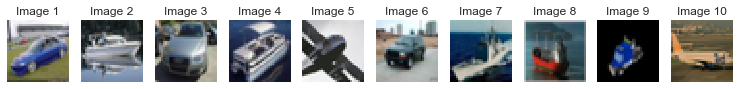

In [47]:
X10 = pix_test[0:10]
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(13, 2))
for i,axis in enumerate(axes):
    flat_img = X10[i,:]
    img = flat_img.reshape(32, 32, 3)
    axis.imshow(img)
    axis.get_xaxis().set_visible(False) 
    axis.get_yaxis().set_visible(False)
    axis.set_title('Image {}'.format(i+1))

plt.show()


In [51]:
alphas = [0.001,0.01,1,10]
for alpha in alphas:
    grid_cv1 = GridSearchCV(pipe,[{'sgdclass__alpha':[alpha]}],cv=5)
    grid_cv1.fit(X_train,y_train)
    prob = grid_cv1.predict_proba(X_test[0:10])
    df = pd.DataFrame(prob,columns=['truck','car','airplane','ship'])
    df.round(2)
    print (df.head())

           truck           car      airplane           ship
0   5.001761e-95  1.000000e+00  1.197879e-28   6.476192e-41
1   1.575403e-42  6.584508e-09  9.998715e-01   1.285247e-04
2   2.695346e-21  1.000000e+00  8.886290e-44   1.199971e-32
3  1.357390e-108  5.879194e-84  7.205360e-16   1.000000e+00
4   7.706284e-66  3.294581e-71  1.000000e+00  2.491938e-123
          truck       car  airplane          ship
0  6.506484e-17  0.995203  0.000088  4.709445e-03
1  1.160328e-15  0.717943  0.000980  2.810771e-01
2  3.673766e-09  0.999093  0.000002  9.049512e-04
3  1.002350e-27  0.000010  0.000238  9.997523e-01
4  2.148255e-17  0.000152  0.999848  2.580916e-13
      truck       car  airplane      ship
0  0.063877  0.736663  0.152733  0.046727
1  0.031988  0.510815  0.187018  0.270179
2  0.269833  0.681727  0.031444  0.016996
3  0.000923  0.056048  0.294285  0.648744
4  0.015825  0.146867  0.837181  0.000126
      truck       car  airplane      ship
0  0.183744  0.480924  0.202051  0.133281
1  0

My observation is that as the alpha value increases, the probability increases too. The only exception is when the model classifies an image (which means it has the highest probability), the probability will decrease and 'shifted' to other categories. I would say, this is a sign of high variance and overfitting.